<a href="https://colab.research.google.com/github/asran974/Binance_AI/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error

In [41]:
!git clone https://github.com/asran974/Binance_AI.git

fatal: destination path 'Binance_AI' already exists and is not an empty directory.


In [43]:
plt.close("all")

data = pd.read_csv("Binance_AI/data.csv", header=None)
print(data)
originalValues = data[4].to_numpy()
values = []
for i in range(len(data) - 1):
    values.append(((originalValues[i] / originalValues[i + 1]) - 1) * 10)
values = np.array(values)
originalValues = originalValues[:len(originalValues) - 1]

# ts = pd.Series(values[:, 1])
# plt.figure()
# plt.plot(ts)
# plt.show()

train_data = values[:-10000]
test_data = values[-10000:]
training_dataset_length = len(train_data)

# train_data = train_data[0:training_dataset_length, :]

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data, test_data], axis=0)

prediction_foresee = 40

                  0         1         2   ...         9             10  11
0      1619973900000  56664.13  56666.77  ...  18.106933  1.025892e+06   0
1      1619973960000  56644.02  56663.43  ...  14.869411  8.421173e+05   0
2      1619974020000  56605.18  56657.55  ...   7.778489  4.404362e+05   0
3      1619974080000  56625.75  56643.60  ...   5.329258  3.017237e+05   0
4      1619974140000  56596.00  56664.14  ...   7.431027  4.208123e+05   0
...              ...       ...       ...  ...        ...           ...  ..
44636  1622652060000  37921.28  37933.14  ...  13.407498  5.083548e+05   0
44637  1622652120000  37911.69  37915.22  ...  28.063457  1.063263e+06   0
44638  1622652180000  37887.62  37940.20  ...  28.029602  1.062750e+06   0
44639  1622652240000  37910.35  37947.94  ...  13.913310  5.276011e+05   0
44640  1622652300000  37901.60  37916.73  ...   5.357725  2.030638e+05   0

[44641 rows x 12 columns]


In [45]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - 1 - time_step - prediction_foresee):
        a = dataset[i:i + time_step]
        dataX.append(a)
        # Get max of the 40 next values
        max_price = originalValues[i + time_step: i + time_step + prediction_foresee].max()
        current_price = originalValues[i]
        prediction = 1 if max_price > current_price else 0
        prediction = .5 if current_price * 1.005 > max_price > current_price * 0.995 else prediction
        dataY.append(prediction)
    return np.array(dataX), np.array(dataY)


def deep_network_LSTM(name_model, x_train, y_train, x_test, y_test, shape, activation_function='sigmoid', opt='adam',
                      epochs=100, batch_size=64):
    # Initialising the RNN
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(shape, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    # Create callbacks
    # callbacks = [EarlyStopping(monitor='val_loss', patience=5),
    # ModelCheckpoint('../models/model.h5'), save_best_only=True,
    # save_weights_only=False)]
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                        batch_size=batch_size, epochs=epochs, verbose=1)
    # model.save(name_model)
    # print("Saved model to disk")

    return (model, history)


def prediction_model_plot(model, x_train, y_train, x_test, y_test, values, look_back):
    global originalValues

    ### Lets Do the prediction and check performance metrics
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)

    ##Transformback to original form
    math.sqrt(mean_squared_error(y_train, train_predict))

    ### Test Data RMSE
    math.sqrt(mean_squared_error(y_test, test_predict))

    ### Plotting
    # shift train predictions for plotting
    # values = np.reshape(values, (len(values), 1))
    values = np.reshape(originalValues, (len(originalValues), 1))
    print(values.shape)
    x = np.arange(len(values))
    print(x)

    trainPredictPlot = np.empty_like(values)
    trainPredictPlot[:] = np.nan
    trainPredictPlot[look_back:len(train_predict) + look_back] = train_predict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(values)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(train_predict) + (look_back * 2) + 1 + 80:len(values) - 1] = test_predict
    # plot baseline and predictions
    fig = plt.figure(figsize=(12, 1), dpi=1200)

    axe1 = fig.add_subplot(111)
    axe1.plot(x, values, linewidth=0.033333)
    axe1.set_ylabel('values')

    axe2 = axe1.twinx()
    axe2.set_ylabel('trainPredictPlot')
    axe2.hist(trainPredictPlot, 100, edgecolor="k",color='yellow')


    axe3 = axe1.twinx()
    axe3.set_ylabel('testPredictPlot')
    axe3.hist(testPredictPlot, 100, edgecolor="k", color='green')
    # plt.plot(trainPredictPlot, linewidth=0.033333)
    # plt.plot(testPredictPlot, linewidth=0.033333)
    # plt.axis([x_min, x_max, y_min, y_max])  # permet de zoomer sur une partie de la courbe
    plt.show()


def plot_hp(model_plot, hyperparameter):
    train_hp = hyperparameter
    validation_hp = 'val_' + hyperparameter
    model = model_plot
    plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(model.history[train_hp], label='train')
    plt.plot(model.history[validation_hp], alpha=0.7, label='validation')
    plt.xlabel(hyperparameter)
    plt.ylabel('Loss')
    plt.legend()
    plt.title(hyperparameter + ' vs Epochs for Model 1', size=25)
    plt.grid()
    plt.show()


def reshape_data(time_step, train_data, test_data):
    # reshape into X=t,t+1,t+2,t+3 and Y=t+4
    x_train, y_train = create_dataset(train_data, time_step)
    x_test, y_test = create_dataset(test_data, time_step)

    # reshape le tout
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)

    return x_train, y_train, x_test, y_test

In [9]:
### Ici Model 1
print('model 1')
time_step1 = 200
x_train1, y_train1, x_test1, y_test1 = reshape_data(time_step1, train_data, test_data)
model1, history1 = deep_network_LSTM('model1', x_train1, y_train1, x_test1, y_test1, time_step1, epochs=1)


model 1
(34399, 200, 1)
(34399,)
(9759, 200, 1)
538/538 [==============================] - 328s 560ms/step - loss: 0.2114 - accuracy: 0.4602 - val_loss: 0.1716 - val_accuracy: 0.4700


(44640, 1)
[    0     1     2 ... 44637 44638 44639]


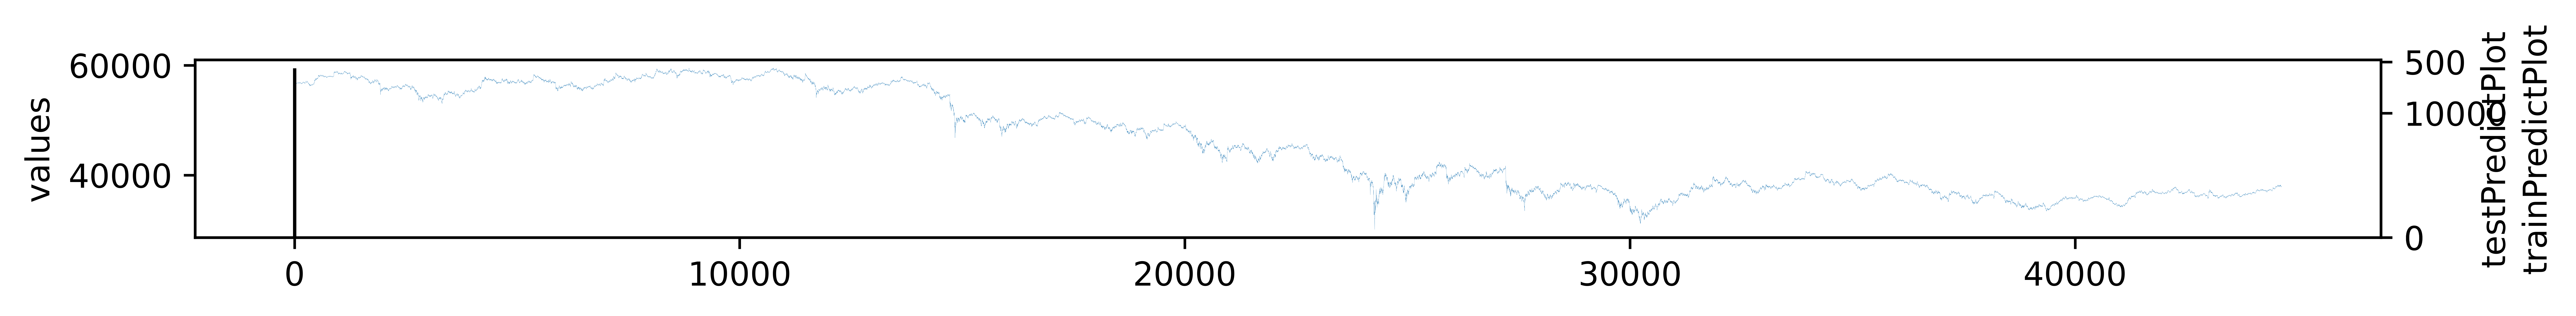

In [46]:
#plot_hp(history1, 'loss')
#plot_hp(history1, 'accuracy')
prediction1 = prediction_model_plot(model1, x_train1, y_train1, x_test1, y_test1, values, look_back=time_step1)